In [1]:
#!pip3 install opencv-python
#!pip install pafy
#!pip install youtube_dl

In [71]:
import cv2
import numpy as np
from PIL import Image
import io

style = {'description_width': '250px'}
layout = {'width': '500px'}

class ImageWidget(object):
    def __init__(self, image=None, display=True):
        self.image_w = widgets.Image(format='PNG')
        self.setImage(image)
        if display == True:
            self.display()
    
    def display(self):
        display(self.image_w)  
    
    def getByteArray(self,image):    
        #return None
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def setImage(self,image):
        if image != None:
            try:
                #print('set image', type(image))
                self.image_w.value = self.getByteArray(image)    
            except Exception as exception: 
                print('ImageWidget')
            
    def getImage(self):
        return Image.open(io.BytesIO(self.image_w.value))

In [3]:
class BaseAction(object):
    
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self.__dict__}

# Crop

In [4]:
# input: image, output cropped image
class CropAction(BaseAction):
    WORLD = 0
    NORMALIZED = 1
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    #def __init__(self, image=None, size=None, min=[0.0,0.0], max=[1.0,1.0]):
    def __init__(self,size=None, min=None, max=None,mode=WORLD):
        self.min  = min
        self.max  = max
        self.size = size
        self.mode = mode
        
    # Problem: + 1    
    def evaluate(self, image=None):
        #return image  return {'image':self.cropped_image}
        if self.mode == self.WORLD:
            return {'image':image.crop(self._flat())}
        return {'image':image.crop(self.fromNormalized(self.flat(), size=image.size))}      
        
    def _flat(self):
        return (self.min[0],self.min[1],self.max[0] + 1,self.max[1] + 1)
    
    def flat(self):
        return (self.min[0],self.min[1],self.max[0],self.max[1])
    
    def normalizeValue(self, value, size):
        return float (value) / size

    def fromNormalizedValue(self, value,size):
        return int(value * size)

    def normalized(self):    
        #print(self.min, self.max, self.size)
        xmin = self.normalizeValue(self.min[0],self.size[0])
        ymin = self.normalizeValue(self.min[1],self.size[1])
        xmax = self.normalizeValue(self.max[0],self.size[0])
        ymax = self.normalizeValue(self.max[1],self.size[1])
        return (xmin,ymin,xmax,ymax)    

    def toNormalized(self):
        if self.mode == self.NORMALIZED:
            return self
        _norm = self.normalized()
        return CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=self.NORMALIZED)
    
    def toWorld(self,size):
        if self.mode == self.WORLD:
            return self
        _world = self.fromNormalized(self.flat(),size=size)
        return CropAction(min=[_world[0],_world[1]], max=[_world[2],_world[3]], mode=self.WORLD)
    
    def fromNormalized(self, values, size=None):    
        if size == None:
            size = self.size
             
        print('fromNormalized',size)        
        xmin = self.fromNormalizedValue(values[0],size[0])
        ymin = self.fromNormalizedValue(values[1],size[1])
        xmax = self.fromNormalizedValue(values[2],size[0])
        ymax = self.fromNormalizedValue(values[3],size[1])
        return [xmin,ymin,xmax,ymax]
    
    def update(self, size=None):
        to = self.normalized()
        self.size = size
        self.min[0] = self.fromNormalizedValue(to[0],size[0])
        self.min[1] = self.fromNormalizedValue(to[1],size[1])
        self.max[0] = self.fromNormalizedValue(to[2],size[0]) 
        self.max[1] = self.fromNormalizedValue(to[3],size[1]) 

# CropWidget

In [36]:
class CropWidget():
    def __init__(self, action=None, parent=None, imageWidget=None, image=None, vstreams=None):
        self.image         = image
        self.result        = {'image':image} 
        self.action       = action
        self.parent       = None
        self.imageWidget  = imageWidget
        self.vstreams     = vstreams
        self.index        = 0
        
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])

        _max = len(vstreams)
        if _max > 0:
            _max = _max -1
        self.imageselectw = widgets.IntSlider(value=0, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button])
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        #self.crop_hbox_y = widgets.HBox([self.cropy0, self.cropy1])
        
        self.vbox   = widgets.VBox([image_select_hbox,self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        #display(self.crop_vbox)
        #self.imageWidget.display()
        
        if action != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
    # INIT    
    def init(self, action=None, parent=None):
        self.videoAction = action
        self.vstreams = action.getVstreams()
        self.image    = self.vstreams[0]
        
        self.action   = CropAction(size=self.image.size,min=[0,0], max=[self.image.size[0],self.image.size[1]])
        self.initMinMax()
        self.imageselectw.max = len(self.vstreams) - 1
        self.imageWidget.setImage(self.image) 
        self.parent = parent
        self.crop_list.options=self.parent.sources.videos[self.parent.id]['bookmarks'].keys()
        
    # RESULT 
    def crop_image(self):
        #return
        #print(self.image.size)
        self.result = self.action.evaluate(image=self.image)
        #print(cropped_image.size)
        self.imageWidget.setImage(self.result['image'])    
        
        
    def initMinMax(self,size=None,cropArea = None):
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            cropArea = self.action.flat()
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image()
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image()

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image()

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image()        
        
    # new bookmark event
    def on_value_submit_crop_name(self,change):
        #print(change)
        self.parent.sources.videos[self.parent.id]['bookmarks'][change.value] = self.action.normalized()
        #self.regions[change.value] = self.action.normalized()
        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        #(cropArea,image.size)
        #print(list(self.crop_list.options),self.crop_list.value, change.value)
        self.crop_list.value = change.value
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            #print(self.regions[change['new']])
            #initMinMax(image.size,bookmark_dict[change['new']])
            #values = fromNormalizedMinMax(bookmark_dict[change['new']],image.size)
            #initMinMax(image.size,values)
            self.crop_name.value = change['new']
            #print('init',self.action.size,self.regions[change['new']])
            #self.initMinMax(self.action.size,self.action.fromNormalized(self.regions[change['new']]))
            self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))
            #self.initMinMax()

    def on_reset_button_clicked(self,b):
        #cropArea        = [0,0,image.size[0],image.size[1]]
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''
        #crop_list.value = ''

    def updateImage(self,index):
        #newimage = getVstream(vstreams=self.vstreams, index=index)   
        newimage = self.vstreams[index]   
        newsize = newimage.size
        self.action.update(newsize)
        self.image = newimage
        #self.initMinMax(self.action.size,self.action.flat())
        self.initMinMax()
        #crop_image() 

    # select image slider
    def on_value_change_imageselectw(self,change):
        #imageselectw.disabled=True
        #global index
        self.index = change['new']
        self.updateImage(self.index)
        #imageselectw.disabled=False    

    def on_next_image_button_clicked(self,b):
        #global vstreams
        _video   = self.videoAction.video
        if self.videoAction.index != self.index:
            self.videoAction = VideoAction(video=_video,index=self.index)
        _vaction = self.videoAction
        self.image = _vaction.readImageOfStream()
        
        self.initMinMax()
        self.crop_image()
        #self.imageWidget.setImage(self.image)
        
        #self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))
        #self.vstreams = getVstreams(video=_video, indexes=[self.index])
        #self.updateImage(self.index)

#cropWidget = CropWidget(action=CropAction(size=image.size, min=[0,0], max=list(image.size)),imageWidget=ImageWidget(), image=image, vstreams=vstreams)   
#cropWidget = CropWidget(action=CropAction(),imageWidget=ImageWidget())


# Resize

In [6]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


class ResizeAction(BaseAction):
    def __init__(self,size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
        self.size=size
        self.use_w=use_w
        self.use_h=use_h
        self.algorithm=algorithm
        
    def evaluate(self,image=None):
        w = self.size[0]
        h = self.size[1]
        #print(size,w,h)
        imagea = image

        ratio = h / imagea.size[1]
        newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

        ratio = w / imagea.size[0]
        h2 = int(ratio * imagea.size[1])
        w2 = int(ratio * imagea.size[0])
        if h2 > h:
            ratio = h / imagea.size[1]
            h2 = int(ratio * imagea.size[1])
            w2 = int(ratio * imagea.size[0])
        newsize = (w2, h2 )

        imageb = imagea.resize(newsize,self.algorithm)

        v = (int((self.size[0]-imageb.size[0])/2), int((self.size[1]-imageb.size[1])/2))
        new_im = Image.new("RGB", self.size) 
        new_im.paste(imageb, v)
        return {'image':new_im}        

In [7]:
class ResizeWidget():
    def __init__(self, action=None, parent=None, imageWidget=None, image=None):
        #self.image        = image
        self.result        = {'image':image} 
        self.action       = action
        self.parent       = parent
        self.imageWidget  = imageWidget
                
        self.algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
        #algorithmw.observe(self.algorithmw_on_change,'value') 
        self.sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
        self.sizew.observe(self.sizew_on_change,'value') 

        self.widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
        self.heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
        self.update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
        self.update_button.on_click(self.on_update_button_clicked)  
        self.vbox   = widgets.VBox([self.algorithmw,self.sizew,self.widthw,self.heightw,self.update_button])
        #display(resize_vbox)    
        #self.imageWidget.display()
        
    def algorithmw_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            print (change['new'])

    def sizew_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.widthw.value  =  str(change['new'][0])        
            self.heightw.value =  str(change['new'][1])  

    # the result: resized_image    
    def on_update_button_clicked(self,b):  
        image = self.parent.result['image']
        if image != None:
            new_size = (int(self.widthw.value),int(self.heightw.value))
            self.action = ResizeAction(size=new_size,algorithm=self.algorithmw.value)
            self.result = self.action.evaluate(image=image)
            self.imageWidget.setImage(self.result['image'])
        
#resizeWidget = ResizeWidget(action=ResizeAction(),imageWidget=ImageWidget())         

# LiveVideoSources

In [53]:
import json
import pafy 

class LiveVideoSources():
    def __init__(self, filename='videos.json'):
        self.filename = filename
        
        self.videos = None
        self.load()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {'filename':self.filename}}     
        
    def load(self):
        with open(self.filename, 'r') as fp:
            self.videos = json.load(fp)  
            #return videos
            
    def save(self,filename=None):
        if filename == None:
            filename = self.filename
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.videos, f, ensure_ascii=False, indent=4)

# LiveVideoSourcesWidget

In [29]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class LiveVideoSourcesWidget():
    def __init__(self, child=None):
        self.sources = None
        self.video = None
        self.id = None
        self.child = child
        self.action = None
        
        self.video_filename = widgets.Text(description = 'filename',value = 'videos.json', style=vstyle, layout=vlayout,disabled=False)    
        self.video_save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.video_save_button.on_click(self.on_video_save_button_clicked)  
        self.video_load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.video_load_button.on_click(self.on_video_load_button_clicked)  
        self.video_delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.video_delete_button.on_click(self.on_video_delete_button_clicked)  
        self.video_urls = widgets.Dropdown(description='videos', style=vstyle, layout=vlayout,disabled=False)
        self.video_urls.observe(self.video_urls_on_change)
        file_hbox = widgets.HBox([self.video_filename,self.video_load_button,self.video_save_button])
        video_urls_hbox = widgets.HBox([self.video_urls,self.video_delete_button])
        file_vbox =   widgets.VBox([file_hbox,video_urls_hbox])
        
        self.video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_url.on_submit(self.on_value_submit_video_url)
        #video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
        self.video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
        self.video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)

        self.vbox   = widgets.VBox([file_vbox, self.video_url,self.video_streams,self.video_title,
                                     self.video_location,self.video_country,self.video_objects])

        #display(video_vbox)
    
    def videoContainerTo_Dict(self):
        container = dict()
        container['url'] = self.video_url.value
        #container['streams'] = video_streams.options
        container['title'] = self.video_title.value
        container['location'] = self.video_location.value
        container['country'] = self.video_country.value
        container['objects'] = self.video_objects.value

        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        bookmark_dict = dict()
        bookmark_dict['reset'] = cropNormalizedArea
        container['bookmarks'] = bookmark_dict
        return container

    def setVideoContainer(self,container):
        self.video_url.value = container['url']
        #container['streams'] = video_streams.options
        self.video_title.value = container['title'] 
        self.video_location.value = container['location'] 
        self.video_country.value = container['country'] 
        self.video_objects.value = container['objects'] 

        #cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        #bookmark_dict = dict()
        #bookmark_dict['reset'] = cropNormalizedArea
        #container['bookmarks'] = bookmark_dict
        
    def on_value_submit_video_url(self,change):
        print(change)
        global video
        video = pafy.new(change.value)
        self.video_title.value = video.title.rsplit('2021')[0].rstrip()
        self.video_streams.options = video.streams
        self.video_streams.value = video.streams[0]
        self.video_streams.disabled = False
        #global vstreams
        #vstreams = getVstreams(video)      
        
    def video_urls_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.id = change['new']
            url = self.sources.videos[change['new']]['url']   
            self.video = video = pafy.new(url)
            self.setVideoContainer(self.sources.videos[change['new']])
            #global vstreams
            #vstreams = getVstreams(video)
            
            if self.child != None:
                action = VideoAction(sources=self.sources,id=self.id,video=self.video)
                self.child.init(action=action, parent=self)
            
    def on_video_load_button_clicked(self,b): 
        filename = self.video_filename.value
        self.sources = LiveVideoSources(filename)
        #global videos
        #videos = loadVideosFile(filename=filename)
        self.video_urls.options = list(self.sources.videos.keys())
        #global video
        #print(list(videos.keys())[0])
        #print(videos.get(list(videos.keys())[0]))
        #video = pafy.new(videos.get(list(videos.keys())[0])['url'])
        #global vstreams
        #vstreams = getVstreams(video)

    def on_video_save_button_clicked(self,b):
        #global videos
        filename = self.video_filename.value
        #videos = loadVideosFile(filename=filename)
        container = self.videoContainerTo_Dict()
        #key = container['url'].rsplit('/')[3]
        key = self.video.videoid
        self.sources.videos[key] = container
        self.video_urls.options = list(self.sources.videos.keys())
        #print(videos)
        self.sources.save()
        #saveVideosFile(filename=filename,videos=videos)       
        
    def on_video_delete_button_clicked(self,b):
        pass

# Video Action

In [89]:
import pafy
import cv2
import time
import json

class VideoAction(BaseAction):
    #def __init__(self, name='_hEh5wF6lxE',index=0,skipframes=0):
    def __init__(self, sources=None, id=None, index=0, skipframes=0, video=None):
        #_entry = videos[name]
        #_video  = pafy.new(_entry['url'])
        self.sources = sources
        self.id = id
        self.index = index
        self.skipframes = skipframes
        self.init(sources=sources, video=video)
        
    def dict(self):
        parameters = {'id':self.id,'index':self.index,'skipframes':self.skipframes}
        return {'class' : self.__class__.__name__, 'parameters' : parameters} 
        
    def init(self, sources=None, video=None):
        self.video = video
        if video == None and sources != None:
            self.sources = sources
            url = self.sources.videos[self.id]['url']   
            self.video = video = pafy.new(url)
        
        if video != None:
            self.stream = video.streams[self.index]
            self.capture = cv2.VideoCapture(self.stream.url)
        
    def saveVideo(self,filename='videos.json', videos=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(videos, f, ensure_ascii=False, indent=4)
        
    def loadVideo(self,filename='videos.json'):
        with open('videos.json', 'r') as fp:
            videos = json.load(fp)  
            return videos

    def readImage(self):
        #capture = cv2.VideoCapture(stream.url)
        self.skipFrames(self.skipframes)
        grabbed, frame = self.capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None

    def readImages(self,number, skipframes=0):
        #global images
        images = []
        #capture = cv2.VideoCapture(stream.url)

        for idx in range(0, number):
            grabbed, frame = self.capture.read()
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            images.append(image)

            for i in range(0, skipframes):
                grabbed, frame = self.capture.read()
                #print('skip',i)
        return images

    def skipFrames(self,skipframes=0):
        for i in range(0, skipframes):
                grabbed, frame = self.capture.read()
    
    def _readImageOfStream(self,stream):
        capture = cv2.VideoCapture(stream.url)
        #self.skipFrames(self.skipframes)
        grabbed, frame = capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None
    
    def getVstreams(self,indexes=None):
        global vstreams
        vstreams=[]
        for stream in self.video.streams:
            if indexes == None:
                image = self._readImageOfStream(stream)
                vstreams.append(image)
            else:
                vstreams.append(None) 

        if indexes != None:
            for index in indexes:
                image = self._readImageOfStream(video.streams[index])
                vstreams[index] = image
        return vstreams

    def getVstream(self,vstreams=None, index=None):
        if vstreams[index] == None:
            image = readImageOfStream(video.streams[index])
            vstreams[index] = image
        return vstreams[index]


# Application

In [90]:
_imageWidget = ImageWidget(display=False)
_crop = CropWidget(vstreams=[], imageWidget=_imageWidget)
_videoSources = LiveVideoSourcesWidget(child=_crop)
_resize = resizeWidget = ResizeWidget(action=ResizeAction(),parent=_crop,imageWidget=_imageWidget)

tab  = widgets.Tab(children = [_videoSources.vbox, _crop.vbox, _resize.vbox])
tab.set_title(0, 'videos')
tab.set_title(1, 'crop')
tab.set_title(2, 'resize')
display(tab)
_imageWidget.display()

Image(value=b'', format='PNG')

In [91]:
#VideoAction(sources=_videoSources.sources,id=_videoSources.id).dict()


def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])
#createActionOfDict(_videoSources.sources.dict()).videos

#_crop.videoAction.dict()['parameters']['index']=2
_action = _crop.videoAction.dict()
_action= createActionOfDict(_action)

In [117]:
_action.init(sources=_videoSources.sources)
#_videoSources.sources.dict()

In [114]:
df['parameters']['index']=2

In [113]:
df = _action.dict()

In [116]:
_action= createActionOfDict(df)

In [139]:
{ **df['parameters'], **{'index':3,'skipframes':5} }

def modify_parameters(old,new):
    #return {'class':old['class']}
    return {'class':old['class'],'parameters':{**old['parameters'],**new}}

_action = merge_dict(_crop.videoAction.dict(), {'index':4,'skipframes':5})
_action= createActionOfDict(_action)
_action.init(sources=_videoSources.sources)

fromNormalized (700, 500)


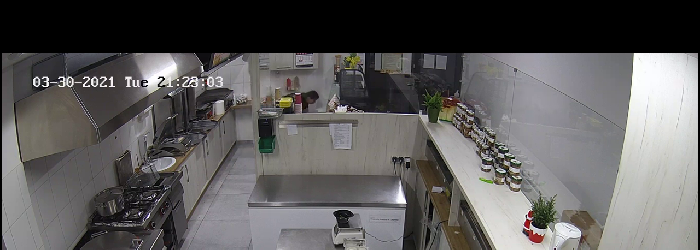

In [236]:
CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=ResizeAction(size=(700,500)).evaluate(image=_action.readImage())['image'])['image']